In [14]:
import os
import sys
import json
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from itertools import combinations
from scipy.stats import shapiro, f_oneway, kruskal
from sklearn.metrics import classification_report, confusion_matrix
from statsmodels.stats.multicomp import MultiComparison

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(os.path.join(module_path))

from functions.plotting import plot_bars, plot_bar_from_dict

WIDTH = 150
HEIGHT = 150

In [15]:
data_dir = os.path.join(
    '..',
    '..',
    '..',
    'data1',
    'images_original_inception_resnet_v2_150x150_categorized')
test_data_dir = os.path.join(data_dir, 'validation')
test_ds = keras.utils.image_dataset_from_directory(
    directory=test_data_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(HEIGHT, WIDTH))

Found 2000 files belonging to 7 classes.


In [16]:
models_dir = os.path.join(
    '..',
    '..',
    'models',
    'data1')
model_names = os.listdir(models_dir)
non_normalized_models = \
    list(
        filter(
            lambda model_file_name: not 'normalization' in model_file_name,
            model_names))

In [4]:
def get_accuracies_and_losses(models: list[str]) -> (dict[str, float], dict[str, float]):
    accuracies = {}
    losses = {}

    for model_name in models:
        model_path = os.path.join(models_dir, model_name)
        model = keras.models.load_model(model_path)
        loss, accuracy = model.evaluate(test_ds)
        accuracies[model_name] = accuracy
        losses[model_name] = loss

    return accuracies, losses

In [25]:
accuracies_wo_norm_data_path = os.path.join('..', '..', 'histories', 'accuracies_wo_norm.json')
losses_wo_norm_data_path = os.path.join('..', '..', 'histories', 'losses_wo_norm.json')

In [26]:
if not os.path.exists(accuracies_wo_norm_data_path):
    accuracies_wo_norm, losses_wo_norm = get_accuracies_and_losses(non_normalized_models)

    with open(accuracies_wo_norm_data_path, 'w') as json_file:
        json.dump(accuracies_wo_norm, json_file, indent=4)
    with open(losses_wo_norm_data_path, 'w') as json_file:
        json.dump(losses_wo_norm, json_file, indent=4)

In [27]:
with open(accuracies_wo_norm_data_path, 'r') as accuracies_file:
    accuracies_wo_norm = json.load(accuracies_file)
with open(losses_wo_norm_data_path, 'r') as losses_file:
    losses_wo_norm = json.load(losses_file)

In [ ]:
root = os.path.join('..', '..', 'plots', 'testing')
accuracies_path = os.path.join(root, 'accuracies.pdf')

plot_bar_from_dict(accuracies_wo_norm, 'Model Accuracies', 'Name', 'Accuracy', accuracies_path)

In [ ]:
losses_path = os.path.join(root, 'losses.pdf')

plot_bar_from_dict(losses_wo_norm, 'Model Losses', 'Name', 'Accuracy', losses_path)

In [8]:
normalized_models = \
    list(
    filter(
        lambda model_file_name: 'normalization' in model_file_name,
        model_names))

In [ ]:
accuracies_w_norm, losses_w_norm = get_accuracies_and_losses(normalized_models)

In [8]:
accuracies_norm_data_path = os.path.join('..', '..', 'histories', 'accuracies_norm.json')
losses_norm_data_path = os.path.join('..', '..', 'histories', 'losses_norm.json')

In [9]:
if not os.path.exists(accuracies_norm_data_path):
    accuracies_norm, losses_norm = get_accuracies_and_losses(normalized_models)

    with open(accuracies_norm_data_path, 'w') as json_file:
        json.dump(accuracies_norm, json_file, indent=4)
    with open(losses_norm_data_path, 'w') as json_file:
        json.dump(losses_norm, json_file, indent=4)

In [10]:
with open(accuracies_norm_data_path, 'r') as losses_file:
    accuracies_norm = json.load(losses_file)
with open(losses_norm_data_path, 'r') as losses_file:
    losses_norm = json.load(losses_file)

In [ ]:
accuracies_path = os.path.join(root, 'accuracies_norm.pdf')

plot_bar_from_dict(accuracies_norm, 'Model Accuracies', 'Name', 'Accuracy', accuracies_path)

In [ ]:
losses_path = os.path.join(root, 'losses_norm.pdf')

plot_bar_from_dict(losses_norm, 'Model Losses', 'Name', 'Accuracy', losses_path)

Analysis part of model testing

In [11]:
model_categories = set(map(lambda name: '_'.join(name.split('_')[:-2]), model_names))
grouped_models = {key: list(filter(lambda name: name.startswith(key), model_names)) for key in model_categories}
keyed_accuracies_wo_norm = {key: [] for key in grouped_models if 'normalization' not in key}
keyed_accuracies_norm = {key: [] for key in grouped_models if 'normalization' in key}
keyed_losses_wo_norm = {key: [] for key in grouped_models if 'normalization' not in key}
keyed_losses_norm = {key: [] for key in grouped_models if 'normalization' in key}


def categorize_numbers(for_dict: dict[str, list[float]], numbers_dict: dict[str, float]) -> None:
    for group, value in for_dict.items():
        vals = [
            value for key, value in numbers_dict.items()
            if key.startswith(group)]

        value.extend(vals)


categorize_numbers(keyed_accuracies_norm, accuracies_norm)
categorize_numbers(keyed_accuracies_wo_norm, accuracies_wo_norm)
categorize_numbers(keyed_losses_norm, losses_norm)
categorize_numbers(keyed_losses_wo_norm, losses_wo_norm)

In [12]:
accuracies_from_norm_models = pd.DataFrame(keyed_accuracies_norm)
accuracies_from_no_norm_models = pd.DataFrame(keyed_accuracies_wo_norm)
losses_from_norm_models = pd.DataFrame(keyed_losses_norm)
losses_from_no_norm_models = pd.DataFrame(keyed_losses_wo_norm)

In [13]:
accuracies_from_norm_models.describe()

,inception_ignoring_imbalance_2_only_bottom_half_layers_trainable_samplewise_normalization,inception_ignoring_imbalance_4_only_bottom_half_layers_trainable_with_attention_module_on_top_and_samplewise_normalization,inception_ignoring_imbalance_3_whole_model_trainable_with_attention_module_on_top_and_samplewise_normalization,inception_ignoring_imbalance_1_whole_model_trainable_samplewise_normalization
count,30.000000,30.000000,30.000000,30.000000
mean,0.752600,0.759717,0.753100,0.748417
std,0.014671,0.011242,0.018877,0.016311
min,0.714000,0.739000,0.700500,0.705000
25%,0.747000,0.752125,0.746750,0.741000
50%,0.754750,0.759250,0.758000,0.753250
75%,0.762000,0.766375,0.765250,0.760500
max,0.782000,0.778500,0.783000,0.769000


In [14]:
accuracies_from_no_norm_models.describe()

,inception_ignoring_imbalance_1_whole_model_trainable,inception_ignoring_imbalance_3_whole_model_trainable_with_attention_module_on_top,inception_ignoring_imbalance_4_only_bottom_half_layers_trainable_with_attention_module_on_top,inception_ignoring_imbalance_2_only_bottom_half_layers_trainable
count,30.000000,30.000000,30.000000,30.000000
mean,0.774250,0.793567,0.792917,0.792350
std,0.016210,0.010632,0.007862,0.013289
min,0.733500,0.777000,0.777500,0.762000
25%,0.769125,0.782750,0.788750,0.784375
50%,0.776500,0.795500,0.794250,0.794250
75%,0.784875,0.799750,0.797375,0.801750
max,0.801500,0.816000,0.805000,0.813500


In [15]:
losses_from_norm_models.describe()

,inception_ignoring_imbalance_2_only_bottom_half_layers_trainable_samplewise_normalization,inception_ignoring_imbalance_4_only_bottom_half_layers_trainable_with_attention_module_on_top_and_samplewise_normalization,inception_ignoring_imbalance_3_whole_model_trainable_with_attention_module_on_top_and_samplewise_normalization,inception_ignoring_imbalance_1_whole_model_trainable_samplewise_normalization
count,30.000000,30.000000,30.000000,30.000000
mean,0.703292,0.673036,0.691220,0.709701
std,0.044011,0.026645,0.048443,0.052602
min,0.652724,0.629656,0.641208,0.636466
25%,0.676151,0.650746,0.659710,0.674715
50%,0.699332,0.670872,0.675271,0.692928
75%,0.722880,0.694725,0.706006,0.743005
max,0.869296,0.722168,0.837553,0.825080


In [16]:
losses_from_no_norm_models.describe()

,inception_ignoring_imbalance_1_whole_model_trainable,inception_ignoring_imbalance_3_whole_model_trainable_with_attention_module_on_top,inception_ignoring_imbalance_4_only_bottom_half_layers_trainable_with_attention_module_on_top,inception_ignoring_imbalance_2_only_bottom_half_layers_trainable
count,30.000000,30.000000,30.000000,30.000000
mean,0.628121,0.587635,0.582946,0.596638
std,0.046395,0.022151,0.018216,0.033383
min,0.572206,0.538928,0.552645,0.541605
25%,0.596247,0.571949,0.572053,0.575664
50%,0.621229,0.584879,0.578076,0.590225
75%,0.644392,0.601979,0.592483,0.625841
max,0.747070,0.633576,0.641276,0.668844


In [17]:
ALPHA = .05
anova_testable_groups = []
kruskal_walis_testable_groups = []


def assign_models_to_groups(models: pd.DataFrame) -> None:
    for col in models.columns:
        _, p_value = shapiro(models[col])

        if p_value >= ALPHA:
            anova_testable_groups.append(col)
        else:
            kruskal_walis_testable_groups.append(col)


assign_models_to_groups(accuracies_from_norm_models)
assign_models_to_groups(accuracies_from_no_norm_models)

In [18]:
anova_values = []
kruskal_values = []
anova_cols = []

for col in anova_testable_groups:
    if col in accuracies_from_norm_models:
        anova_values.append(accuracies_from_norm_models[col].tolist())
        anova_cols.append(col)
    if col in accuracies_from_no_norm_models:
        anova_values.append(accuracies_from_no_norm_models[col].tolist())
        anova_cols.append(col)

for col in kruskal_walis_testable_groups:
    if col in accuracies_from_norm_models:
        kruskal_values.append(accuracies_from_norm_models[col].tolist())
    if col in accuracies_from_no_norm_models:
        kruskal_values.append(accuracies_from_no_norm_models[col].tolist())


f_stat_anova, p_value_anova = f_oneway(*anova_values)
h_stat_kruskal, p_value_kruskal = kruskal(*kruskal_values)

print(f'ANOVA p-value: {p_value_anova}')
print(f'Kruskal-Wallis p-value: {p_value_kruskal}')

ANOVA p-value: 4.064446737409379e-37
Kruskal-Wallis p-value: 0.17359764347681522


ANOVA p-value is extremely small, practically zero, which strongly indicates that there are significant differences between the means of the groups tested (those groups which passed the normality test). I reject the null hypothesis of equal means. Given this result, it's warranted to proceed to post-hoc analysis (like Tukey's HSD) to find out which specific groups have significantly different means.

Kruskal-Wallis p-value is relatively large (greater than common thresholds like 0.05 or 0.01), which suggests that I fail to reject the null hypothesis for the Kruskal-Wallis test. This indicates that there isn't a statistically significant difference between the median ranks of the groups tested (those groups which failed the normality test).

In [24]:
tukey_vals = list(itertools.chain(*anova_values))
tukey_cols = []
idx = 0

for col in anova_values:
    n_repeat = len(col)
    group = [anova_cols[idx]] * n_repeat
    idx += 1

    tukey_cols.extend(group)

mc = MultiComparison(tukey_vals, tukey_cols)
tukeyhsd_result = mc.tukeyhsd()

with open(os.path.join('..', '..', 'debug_data', 'tukeyhsd.test'), 'w') as test_file:
    test_file.write(str(tukeyhsd_result))

Now Cohen-d values will be calculated for quantifying difference magnitudes between groups

In [31]:
significant_pairs = np.column_stack((tukeyhsd_result.reject, tukeyhsd_result.reject2))
group_data = {}

for group, value in zip(tukey_cols, tukey_vals):
    if group not in group_data:
        group_data[group] = []

    group_data[group].append(value)


def cohen_d(group1, group2):
    diff = np.mean(group1) - np.mean(group2)
    pooled_var = ((len(group1) - 1) * np.var(group1, ddof=1) + (len(group2) - 1) * np.var(group2, ddof=1)) / (len(group1) + len(group2) - 2)
    d_val = diff / np.sqrt(pooled_var)

    return d_val


group_indices = range(len(tukeyhsd_result.groupsunique))
all_pairs = list(combinations(group_indices, 2))
significant_pairs_idx = np.where(tukeyhsd_result.reject)[0]

for pair_idx in significant_pairs_idx:
    i, j = all_pairs[pair_idx]
    d = cohen_d(group_data[tukeyhsd_result.groupsunique[i]], group_data[tukeyhsd_result.groupsunique[j]])
    print(f"Cohen's d for {tukeyhsd_result.groupsunique[i]} and {tukeyhsd_result.groupsunique[j]}: {d}")


Cohen's d for inception_ignoring_imbalance_1_whole_model_trainable and inception_ignoring_imbalance_2_only_bottom_half_layers_trainable: -1.221165665357446
Cohen's d for inception_ignoring_imbalance_1_whole_model_trainable and inception_ignoring_imbalance_2_only_bottom_half_layers_trainable_samplewise_normalization: 1.400417986494237
Cohen's d for inception_ignoring_imbalance_1_whole_model_trainable and inception_ignoring_imbalance_3_whole_model_trainable_with_attention_module_on_top: -1.4091524420796084
Cohen's d for inception_ignoring_imbalance_1_whole_model_trainable and inception_ignoring_imbalance_4_only_bottom_half_layers_trainable_with_attention_module_on_top: -1.4652732770150376
Cohen's d for inception_ignoring_imbalance_1_whole_model_trainable and inception_ignoring_imbalance_4_only_bottom_half_layers_trainable_with_attention_module_on_top_and_samplewise_normalization: 1.0418961208303033
Cohen's d for inception_ignoring_imbalance_2_only_bottom_half_layers_trainable and incepti

inception_ignoring_imbalance_2_only_bottom_half_layers_trainable_samplewise_normalization: Mean = 0.75, Std = 0.01
inception_ignoring_imbalance_4_only_bottom_half_layers_trainable_with_attention_module_on_top_and_samplewise_normalization: Mean = 0.76, Std = 0.01
inception_ignoring_imbalance_1_whole_model_trainable: Mean = 0.77, Std = 0.02
inception_ignoring_imbalance_3_whole_model_trainable_with_attention_module_on_top: Mean = 0.79, Std = 0.01
inception_ignoring_imbalance_4_only_bottom_half_layers_trainable_with_attention_module_on_top: Mean = 0.79, Std = 0.01
inception_ignoring_imbalance_2_only_bottom_half_layers_trainable: Mean = 0.79, Std = 0.01


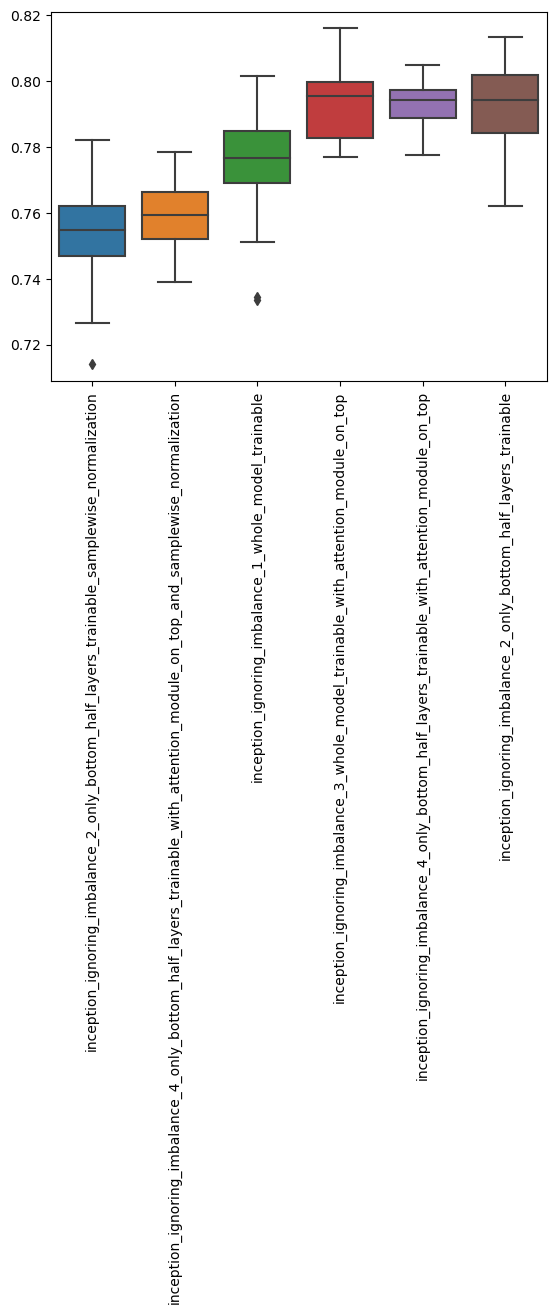

In [36]:
group_stats = {group: (np.mean(values), np.std(values)) for group, values in group_data.items()}

for group, (mean, std) in group_stats.items():
    print(f"{group}: Mean = {mean:.2f}, Std = {std:.2f}")

sns.boxplot(x=tukey_cols, y=tukey_vals)
plt.xticks(rotation=90)
plt.show()

In conclusion:

1. ANOVA and Kruskal-Wallis tests have shown that there are statistically significant differences between the models performances, which is confirmed by the boxplots interpretation. A null hypothesis of all the groups having the same mean could have been rejected.
2. Cohen-d values for the best performing models, that is:
    - 3_whole_model_trainable_with_attention_module_on_top
    - 4_only_bottom_half_layers_trainable_with_attention_module_on_top
    - 2_only_bottom_half_layers_trainable
   have shown that magnitudes of the differences of those models are statistically insignificant.
3. At the same time those are the 3 best performing models. Visual inspection shows that the whiskers of the 3_whole_model_trainable_with_attention_module_on_top and 2_only_bottom_half_layers_trainable plots are longer than those of 3_whole_model_trainable_with_attention_module_on_top. That means that the two models are more prone to produce more spread out results, while the 3_whole_model_trainable_with_attention_module_on_top produces more consistent results.
4. From the above it can be concluded that either the 3_whole_model_trainable_with_attention_module_on_top model or 4_only_bottom_half_layers_trainable_with_attention_module_on_top are the best ones.

Now let's pick the best model instance to see the confusion matrix for best model.

In [28]:
name = ''
best_acc = 0

for key, value in accuracies_wo_norm.items():
    if '3_whole_model_trainable_with_attention_module_on_top' in key and value > best_acc:
        name = key
        best_acc = value

model_path = os.path.join(models_dir, name)
model = keras.models.load_model(model_path)
prediction = model.predict(test_ds)

63/63 [==============================] - 7s 65ms/step


It seems the models have been trained on a dataset with 9 classes, but at some point 2 of them that were empty have been removed which resulted in the last class ordinal number being wrong during prediction time. Here's the adjustment:

In [33]:
y_pred_labels = np.argmax(prediction, axis=1)
y_pred_labels[y_pred_labels == 8] = 6

              precision    recall  f1-score   support

       akiec       0.03      0.03      0.03        65
         bcc       0.04      0.05      0.05       102
         bkl       0.10      0.12      0.11       219
          df       0.00      0.00      0.00        23
         mel       0.11      0.09      0.10       222
          nv       0.67      0.67      0.67      1341
        vasc       0.04      0.04      0.04        28

    accuracy                           0.48      2000
   macro avg       0.14      0.14      0.14      2000
weighted avg       0.47      0.48      0.48      2000



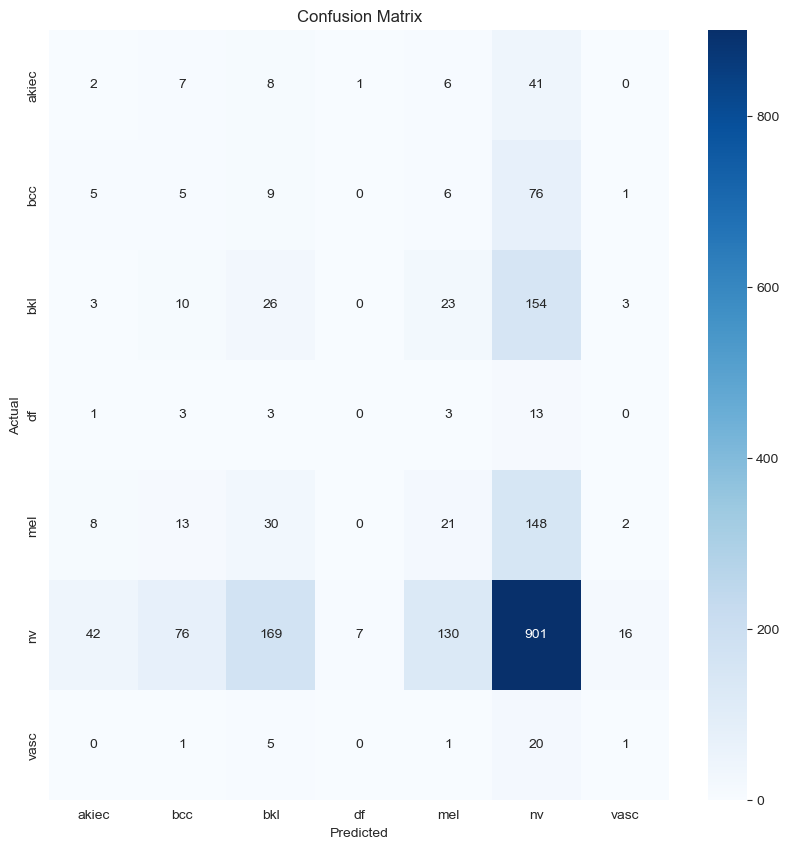

In [35]:
y_test = []

for _, labels in test_ds:
    y_test.extend(np.argmax(labels.numpy(), axis=-1))

y_test = np.array(y_test)
report = classification_report(y_test, y_pred_labels, target_names=test_ds.class_names, zero_division=0)
print(report)

cm = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_ds.class_names, yticklabels=test_ds.class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

It's very visible that the model despite having over 81% accuracy, still gets confused a lot by the classes that are not often encountered in the dataset.